In [1]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D,\
Add, Multiply, UpSampling2D, Dropout, concatenate, AveragePooling2D, Reshape

from keras.layers.advanced_activations import LeakyReLU

#from utils import LeakyReLU, average_endpoint_error, pad, antipad
 
from keras import layers
import keras
    
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import pandas as pd

import tensorflow as tf

from keras.utils.io_utils import HDF5Matrix
import keras.backend as K

Using TensorFlow backend.
C:\Users\Yoon\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Yoon\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Yoon\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Yoon\AppData\Roaming

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = tf.Session(config=config)

In [3]:
HIGHT = 480
WIDTH = 640
CHANNELS = 6

In [4]:
test_list = pd.read_csv('data/adobe240fps/test_list.txt',header=None)
train_list = pd.read_csv('data/adobe240fps/train_list.txt',header=None)

In [5]:
data_length = len(os.walk("data/train/flow").__next__()[1])
picNum= 0

for i in range(data_length):
    #frame_length = len(os.walk("data/train/resize/"+train_list.iloc[i,0].split('.')[0]).__next__()[2])-8
    frame_length = len(os.walk("data/train/half/"+train_list.iloc[i,0].split('.')[0]).__next__()[2])-8
    picNum += frame_length

print(picNum)

101599


In [ ]:
data_length = len(os.walk("data/train/flow").__next__()[1])
picNum= 0

for i in range(data_length):
    #frame_length = len(os.walk("data/train/resize/"+train_list.iloc[i,0].split('.')[0]).__next__()[2])-8
    frame_length = len(os.walk("data/train/half/"+train_list.iloc[i,0].split('.')[0]).__next__()[2])-8
    picNum += frame_length

fileList = picNum


x1_val = np.array(np.load('data load/half/x1_640-480_20.npz')['x'])
x2_val = np.array(np.load('data load/half/x2_640-480_20.npz')['x'])
y_val = np.array(np.load('data load/half/y_640-480_20.npz')['y'])

x1_load = np.load('data load/half/x1_640-480_1.npz')
x2_load = np.load('data load/half/x2_640-480_1.npz')
y_load = np.load('data load/half/y_640-480_1.npz')

Data Generator

In [ ]:

def imageLoader(files, batch_size):
    
    #L = len(files)
    L = files
    load_count = 0

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size
        #load_count = 0
        
        while load_count < L:
            
            limit = min(batch_end, 5000)
        
            #x1_load = np.load('data load/half/x1_640-480_%d.npz'%load_count)
            #x2_load = np.load('data load/half/x2_640-480_%d.npz'%load_count)
            #y_load = np.load('data load/half/y_640-480_%d.npz'%load_count)

            X1 = np.array(x1_load['x'][batch_start:batch_end])
            X2 = np.array(x2_load['x'][batch_start:batch_end])
            Y = np.array(y_load['y'][batch_start:batch_end])
            
            yield(X1, Y)
            load_count += 1

#        while batch_start < L:
#            limit = min(batch_end, L)
#            x1_load = np.load('data load/half/x1_640-480_%d.npz'%)
#            X1 = someMethodToLoadImages(files[batch_start:limit])
#            X2 = 
#            Y = someMethodToLoadTargets(files[batch_start:limit])

         #   yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
def imageLoader(files, batch_size):
    
    #L = len(files)
    L = files
    load_count = 0

    #this line is just to make the generator infinite, keras needs that    


    batch_start = 0
    batch_end = batch_size
    #load_count = 0
        
    while load_count < L:

        limit = min(batch_end, 5000)

        #x1_load = np.load('data load/half/x1_640-480_%d.npz'%load_count)
        #x2_load = np.load('data load/half/x2_640-480_%d.npz'%load_count)
        #y_load = np.load('data load/half/y_640-480_%d.npz'%load_count)

        X1 = np.array(x1_load['x'][batch_start:batch_end])
        X2 = np.array(x2_load['x'][batch_start:batch_end])
        Y = np.array(y_load['y'][batch_start:batch_end])

        load_count += 1 

        batch_start += batch_size   
        batch_end += batch_size

        return ([X1,X2],Y)

In [13]:
#filename = "data load/half/half.hdf5"
filename = "data load/resize.hdf5"

split_pos = 90000

X1_train = HDF5Matrix(filename, 'image_x0', end = split_pos)
X2_train = HDF5Matrix(filename, 'image_x1', end = split_pos)
Y_train = HDF5Matrix(filename, 'image_y', end = split_pos)

X1_val = HDF5Matrix(filename, 'image_x0', start = split_pos)
X2_val = HDF5Matrix(filename, 'image_x1', start = split_pos)
Y_val = HDF5Matrix(filename, 'image_y', start = split_pos)

HIGHT = X1_train.shape[1]
WIDTH = X1_train.shape[2]

print(HIGHT)
print(WIDTH)

192
320


Unet

In [14]:
#inputs = Input((HIGHT, WIDTH, CHANNELS))
inputsA = Input((HIGHT, WIDTH, 3))
inputsB = Input((HIGHT, WIDTH, 3))

#input 1
convA1 = Conv2D(64, 5, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(inputsA)
convA2 = Conv2D(128, 5, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(convA1)
convA3 = Conv2D(256, 1, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(convA2)

#input 2
convB1 = Conv2D(64, 5, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(inputsB)
convB2 = Conv2D(128, 5, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(convB1)
convB3 = Conv2D(256, 1, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(convB2)

#inputs = concatenate([A.output,B.output])
inputs = concatenate([convA3, convB3])

conv1 = Conv2D(32, 7, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(32, 7, activation=LeakyReLU(alpha=0.1), padding='same', kernel_initializer='he_normal')(conv1)
pool1 = AveragePooling2D(pool_size=(2,2))(conv1)

conv2 = Conv2D(64, 5, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(64, 5, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = AveragePooling2D(pool_size=(2,2))(conv2)

conv3 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = AveragePooling2D(pool_size=(2,2))(conv3)

conv4 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4) 
pool4 = AveragePooling2D(pool_size=(2,2))(drop4)

conv5 = Conv2D(512, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(512, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(256, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size=(2,2))(drop5))
merge6 = concatenate([drop4,up6], axis=3)
conv6 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(128, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(64, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(64, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(32, 2, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(32, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(6, 3, activation = LeakyReLU(alpha=0.1), padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv9 = Conv2D(6, 1, padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Reshape((2,HIGHT,WIDTH,3))(conv9)

#model = Model(inputs,conv9)
model = Model([inputsA,inputsB],conv9)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 192, 320, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 192, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 192, 320, 64) 4864        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 192, 320, 64) 4864        input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-5, thresh=0.5):
    y_pred = y_pred > thresh
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return -(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(smooth, thresh):
    def dice(y_true, y_pred):
        return -dice_coef(y_true, y_pred, smooth, thresh)
    return dice

model_dice = dice_loss(smooth=1e-5, thresh=0.5)

In [ ]:
def dice_coef(y_pred,y_true):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(K.argmax(y_pred, axis=1))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_pred, y_true):
    return dice_coef(y_pred, y_true)

In [8]:
import keras.backend as K

def custom_loss(y_true, y_pred):
    #V = y_pre - y_true
    #custom_loss_value = np.linalg.norm(V, axis=1, ord=2)
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [15]:
#model.compile(optimizer = keras.optimizers.Adam(amsgrad=True), loss = 'mse', metrics = ['accuracy'])
#sgd = optimizers.SGD(lr=0.01,momentum=0.9,nesterov=False)
#model.compile(optimizer = sgd, loss = dice_coef, metrics = ['accuracy'])

model.compile(optimizer = keras.optimizers.Adam(amsgrad=True), loss = custom_loss, metrics = ['accuracy'])

In [24]:
early_stopping = EarlyStopping(patience=15, mode='auto', monitor='val_loss')
checkpoint = ModelCheckpoint("checkpoint/two_input_resize_2out_mid.h5", monitor='loss', verbose=1,save_best_only-True, mode='auto', period=1)
history = model.fit([X1_train, X2_train], Y_train, validation_data=([X1_val, X2_val], Y_val),epochs = 50, batch_size = 4, shuffle='batch', callbacks=[early_stopping])

Train on 90000 samples, validate on 11599 samples
Epoch 1/50
90000/90000 [==============================] - 20673s 230ms/step - loss: 5.9552 - acc: 0.7013 - val_loss: 9.3181 - val_acc: 0.7291
Epoch 2/50
90000/90000 [==============================] - 20343s 226ms/step - loss: 5.3123 - acc: 0.7284 - val_loss: 7.6343 - val_acc: 0.7458
Epoch 3/50
90000/90000 [==============================] - 20067s 223ms/step - loss: 4.9434 - acc: 0.7418 - val_loss: 7.3423 - val_acc: 0.7886
Epoch 4/50
90000/90000 [==============================] - 20091s 223ms/step - loss: 4.6989 - acc: 0.7489 - val_loss: 6.6199 - val_acc: 0.8038
Epoch 5/50
90000/90000 [==============================] - 20075s 223ms/step - loss: 4.4965 - acc: 0.7548 - val_loss: 6.6557 - val_acc: 0.8047
Epoch 6/50
90000/90000 [==============================] - 19999s 222ms/step - loss: 4.3018 - acc: 0.7590 - val_loss: 6.9997 - val_acc: 0.7850
Epoch 7/50
90000/90000 [==============================] - 19948s 222ms/step - loss: 4.1391 - acc: 

KeyboardInterrupt: 

In [25]:
model.save_weights('checkpoint/two_input_resize_2out_2.h5')

In [54]:
num = 0
#pre = model.predict([X1_val[num:num+10],X2_val[num:num+10]])
pre = model.predict([X1_train[num:num+10],X2_train[num:num+10]])

In [55]:
preCh1 = np.zeros((10,HIGHT,WIDTH,3))
preCh2 = np.zeros((10,HIGHT,WIDTH,3))

In [56]:
for i in range(pre.shape[0]):
    preCh1[i] = pre[i,0]
    preCh2[i] = pre[i,1]

In [57]:
for i in range(pre.shape[0]):
    cv2.imwrite('test img/res/ch1/frame%d.jpg'%i,preCh1[i])
    cv2.imwrite('test img/res/ch2/frame%d.jpg'%i,preCh2[i])
    cv2.imwrite('test img/res/ch1/frame%d_true.jpg'%i,Y_val[i+num][0])
    cv2.imwrite('test img/res/ch2/frame%d_true.jpg'%i,Y_val[i+num][1])

In [ ]:
y_load = np.load('data load/half/y_640-480_1.npz')

In [ ]:
test = y_load['y'][:10]

In [ ]:
test.shape

In [ ]:
test

In [30]:
Y_val.shape

(11599, 2, 192, 320, 3)

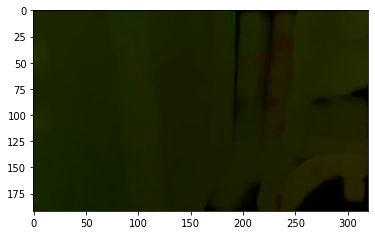

In [49]:
plt.imshow(Y_val[100][1])